In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc

from aerometrics.utils.functions import emission_profile_function
from aerometrics.metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from aerometrics.climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from aerometrics.climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

## Parameters

In [2]:
start_year = 1765
t0 = 2020
time_horizon = 100

sensitivity_rf_co2 = 9.2e-16 # Not used with FaIR
ratio_erf_rf_co2 = 1
efficacy_erf_co2 = 1
unit_value_co2 = 1*10**10

In [3]:
species = "Aviation NOx - CH4 decrease and induced"

In [4]:
unit_value = 1*10**10
variables = {
    "time_horizon_log": (np.log(10), np.log(200))
}
    
n_samples = 100 
dim = len(variables)

sampler = qmc.LatinHypercube(d=dim)
sample = sampler.random(n=n_samples)

l_bounds = [v[0] for v in variables.values()]
u_bounds = [v[1] for v in variables.values()]
scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

df_init = pd.DataFrame(scaled_sample, columns=variables.keys())
df = df_init.copy()
for k in range(0, n_samples):
    df.loc[k, "time_horizon_log"] = np.log(int(np.exp(df_init.loc[k, "time_horizon_log"])))
print(df)

    time_horizon_log
0           3.688879
1           4.234107
2           4.564348
3           5.225747
4           2.995732
..               ...
95          2.772589
96          4.330733
97          4.744932
98          3.637586
99          5.204007

[100 rows x 1 columns]


In [5]:
species_settings_co2 = {"sensitivity_rf": sensitivity_rf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}

metric_list = np.zeros(n_samples)

for i in range(0, n_samples):
    
    time_horizon = int(np.exp(df.loc[i, "time_horizon_log"]))

    if species == "Aviation contrails":
        sensitivity_rf = 2.23e-12
        ratio_erf_rf = 0.42
        efficacy_erf = 1
    elif species == "Aviation NOx - ST O3 increase":
        sensitivity_rf = 25.1e-12 * (14/46)
        ratio_erf_rf = 1.37
        efficacy_erf = 1
    elif species == "Aviation NOx - CH4 decrease and induced":
        sensitivity_rf = -3.90
        ratio_erf_rf = 1.18
        efficacy_erf = 1
    
    end_year = t0 + time_horizon
    background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
    model_settings_co2 = {"background_species_quantities": background_species_quantities}
    model_settings = {"background_species_quantities": background_species_quantities}
    
    emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value_co2)
    emission_profile = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value)
    radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
    radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
    agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
    
    species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
    radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
    agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
    
    gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
    
    metric_list[i] = ratr

In [6]:
if species == "Aviation NOx - CH4 decrease and induced":
    df['metric_log'] = np.log(-metric_list)
else:
    df['metric_log'] = np.log(metric_list)
print(df)

    time_horizon_log  metric_log
0           3.688879    5.527831
1           4.234107    5.121589
2           4.564348    4.871141
3           5.225747    4.329271
4           2.995732    5.958490
..               ...         ...
95          2.772589    6.053925
96          4.330733    5.046195
97          4.744932    4.719782
98          3.637586    5.581375
99          5.204007    4.351830

[100 rows x 2 columns]


In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Variables (logarithm)
X = df.copy()
X["time_horizon_log_2"] = X["time_horizon_log"]**2
X1 = X[["time_horizon_log"]]
X2 = X[["time_horizon_log", "time_horizon_log_2"]]
y = df[["metric_log"]]

# Linear regression (logarithm)
model1 = LinearRegression()
model1.fit(X1, y)
model2 = LinearRegression()
model2.fit(X2, y)

coeffs1 = model1.coef_
intercept1 = model1.intercept_
features1 = X1.columns
equation1 = f"metric_log = {intercept1.item():.4f}"
for i in range(len(features1)):
    equation1 += f" + ({coeffs1[i].item():.4f}) × {features1[i]}"
coeffs2 = model2.coef_
intercept2 = model2.intercept_
features2 = X2.columns
equation2 = f"metric_log = {intercept2.item():.4f}"
for i in range(len(features2)):
    equation2 += f" + ({coeffs2[0, i].item():.4f}) × {features2[i]}"


feature_base1 = features1[0].replace("_log", "")  # ex : "time_horizon"
a1 = intercept1.item()
b1 = coeffs1[0, 0]

coeffs2 = model2.coef_
intercept2 = model2.intercept_
features2 = X2.columns

log_feature = [f for f in features2 if "_log" in f][0]
log2_feature = [f for f in features2 if "_log_2" in f][0]
feature_base2 = log_feature.replace("_log", "")  # ex : "time_horizon"

a2 = intercept2.item()
log_feature = [f for f in features2 if "_log" in f and "_2" not in f][0]
log2_feature = [f for f in features2 if "_log_2" in f][0]
feature_base2 = log_feature.replace("_log", "")

b2 = coeffs2[0, features2.get_loc(log_feature)].item()
c2 = coeffs2[0, features2.get_loc(log2_feature)].item()
C2 = np.exp(a2)

equation2 = f"metric = {C2:.4f} × {feature_base2}^({b2:.4f} + {c2:.4f} × log({feature_base2}))"

y_pred1 = model1.predict(X1)
r21 = r2_score(np.exp(y), np.exp(y_pred1))
rmse1 = mean_squared_error(y, y_pred1)
y_pred2 = model2.predict(X2)
r22 = r2_score(np.exp(y), np.exp(y_pred2))
rmse2 = mean_squared_error(y, y_pred2)

print("Model 1")
print("Equation:", equation1)
print(f"R² : {r21:.4f}")
print(f"RMSE : {rmse1:.4f}")

print("\nModel 2")
print("Equation:", equation2)
print(f"R² : {r22:.4f}")
print(f"RMSE : {rmse2:.4f}")

Model 1
Equation: metric_log = 7.8807 + (-0.6592) × time_horizon_log
R² : 0.9549
RMSE : 0.0057

Model 2
Equation: metric = 634.0429 × time_horizon^(0.1396 + -0.1057 × log(time_horizon))
R² : 0.9976
RMSE : 0.0004


In [8]:
residuals_real1 = (np.exp(y_pred1) - np.exp(y))/np.exp(y)*100
mean_error1 = np.mean(residuals_real1)
median_error1 = np.median(residuals_real1)
residuals_real2 = (np.exp(y_pred2) - np.exp(y))/np.exp(y)*100
mean_error2 = np.mean(residuals_real2)
median_error2 = np.median(residuals_real2)

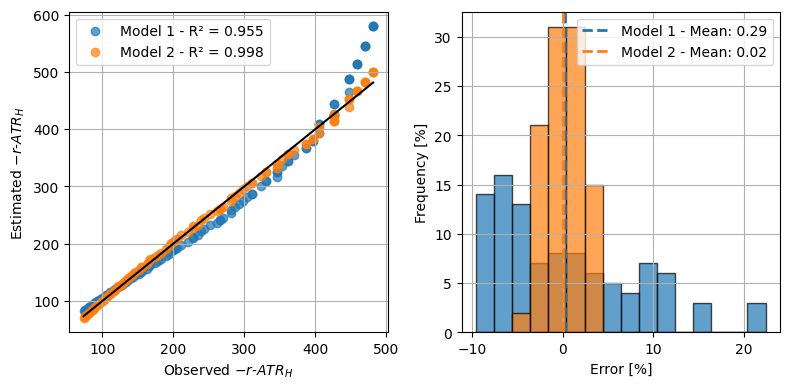

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(np.exp(y), np.exp(y_pred1), label='Model 1 - '+f'R² = {r21:.3f}', alpha=0.7)
axes[0].scatter(np.exp(y), np.exp(y_pred2), label='Model 2 - '+f'R² = {r22:.3f}', alpha=0.7)
axes[0].plot([np.min(np.exp(y)), np.max(np.exp(y))], [np.min(np.exp(y)), np.max(np.exp(y))], color='black')
axes[0].set_xlabel(r"Observed $-r\text{-}ATR_{H}$")
axes[0].set_ylabel(r"Estimated $-r\text{-}ATR_{H}$")
axes[0].legend()
axes[0].grid(True)

combined_min = min(residuals_real1.min().item(), residuals_real2.min().item())
combined_max = max(residuals_real1.max().item(), residuals_real2.max().item())
bin_width = 2
bins = np.arange(combined_min, combined_max + bin_width, bin_width)
axes[1].hist(residuals_real1, bins=bins, color='C0', edgecolor='black', alpha=0.7)
axes[1].hist(residuals_real2, bins=bins, color='C1', edgecolor='black', alpha=0.7)
axes[1].axvline(mean_error1, color='C0', linestyle='--', linewidth=2, label='Model 1 - '+f'Mean: {mean_error1:.2f}')
axes[1].axvline(mean_error2, color='C1', linestyle='--', linewidth=2, label='Model 2 - 'f'Mean: {mean_error2:.2f}')
axes[1].set_xlabel("Error [%]")
axes[1].set_ylabel("Frequency [%]")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("figures/surrogate_model.pdf")
plt.show()